# Define the filtering scale

In [1]:
import aplpy
from astropy.io import fits
#import the pywavan modules
from pywavan import fan_trans, apodize, padding, depad, powspec, gauss_beam, nb_scale
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
path='/Users/robitaij/postdoc/Nichols_MnGSeg/'

source='G012.80'
band='_B6'
array='_12M-'
imagetype='cleanest-jun21'
imagetype1='.image'
#imagetype1='.pbcor'

imagename=source+band+array+imagetype+imagetype1
print(imagename)

G012.80_B6_12M-cleanest-jun21.image


### Plot original image

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -1.392e-03 [aplpy.core]
INFO: Auto-setting vmax to  7.232e-02 [aplpy.core]


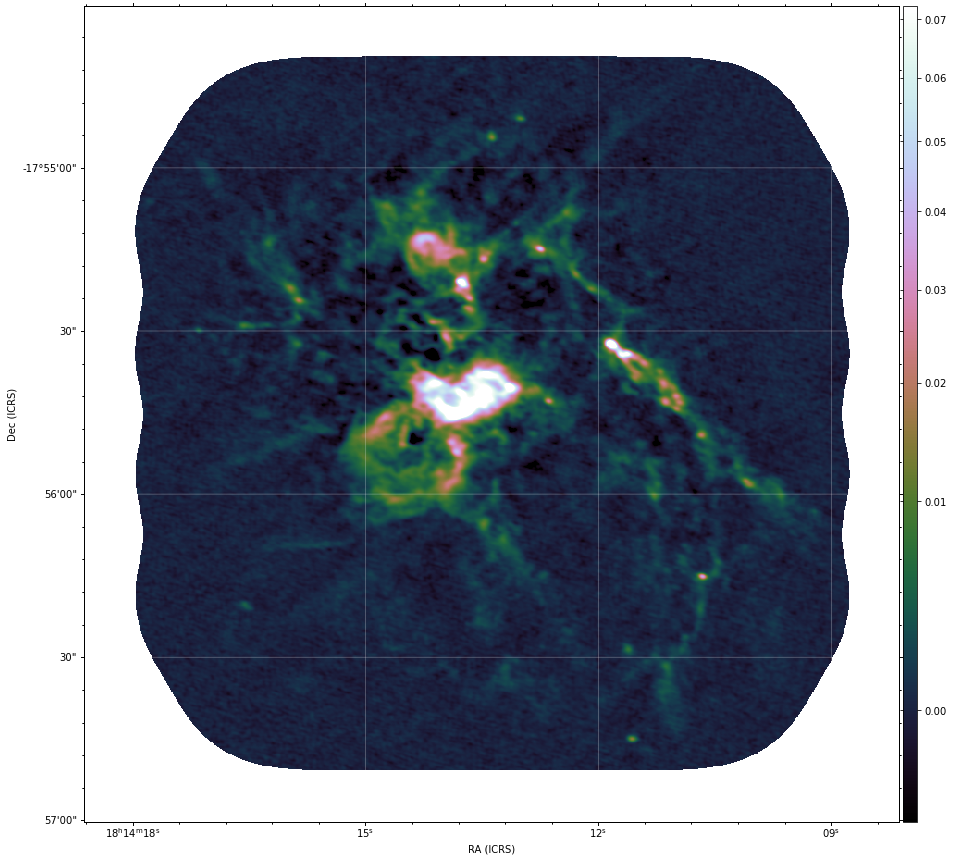

In [3]:
#plot original image for source given above

fig_all = plt.figure(1, figsize=(15,15))
figfile = path+imagename+'.fits'

fig = aplpy.FITSFigure(figfile,figure=fig_all)
fig.show_colorscale(cmap='cubehelix',stretch='sqrt')
fig.add_colorbar()
#fig.add_scalebar(2.8/60.,color='white')
fig.add_grid()
fig.grid.set_color('white')
fig.grid.set_alpha(0.3)
fig.grid.set_linestyle('solid')
#fig.show_rectangles(x1+(x2-x1)/2.,y1+(y2-y1)/2., (x2-x1), (y2-y1), coords_frame='pixel', color='green',linewidth=3.0)

In [4]:
#Read map
HDU = fits.open(figfile)
im_original = HDU[0].data
header = HDU[0].header

### Fourier power spectrum analysis

Resolution armin = 0.0028333333333332


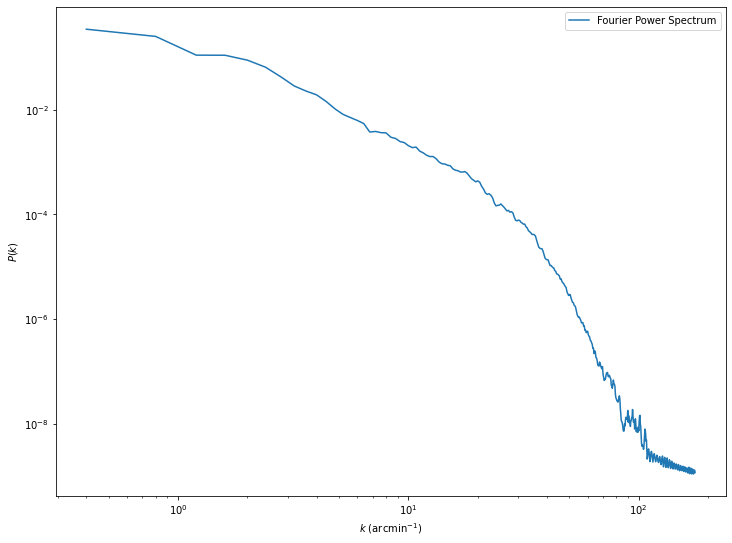

In [5]:
#Resolution in arcmin (size of 1 pixel)
reso = HDU[0].header['CDELT2'] *60
print('Resolution armin =', reso)
meanim = np.nanmean(im_original)

imzm = im_original - meanim 

tab_k, spec_k = powspec(imzm, reso=reso, nan_frame=True)

#Plot Fourier power spectrum
figure(figsize=(12,9))
plot(tab_k,spec_k, label="Fourier Power Spectrum")
xscale('log')
yscale('log')
xlabel(r"$k$ (arcmin$^{-1}$)")
ylabel(r"$P(k)$")
legend()

### Apply MnGSeg

In [6]:
#Set a list of q
q=[2.0]*nb_scale(im_original.shape)
wt, S11a, wav_k, S1a, q = fan_trans(im_original, reso=reso, q=q, smooth=True, skewl=0.4,qdyn=False,nan_frame=True)

print(q)

  0%|          | 0/23 [00:00<?, ?it/s]

[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]


### Reconstruct images

In [7]:
M = nb_scale(im_original.shape)

coherent = np.sum(wt[M:2*M,:,:].real,axis=0) + meanim
Gaussian = np.sum(wt[2*M:3*M,:,:].real,axis=0) + meanim

#fits.writeto(outputpath+imagename+'_cohe.fits',\
#            coherent.real,header,overwrite=True)
#fits.writeto(outputpath+imagename+'_gaussian.fits',\
#            Gaussian.real,header,overwrite=True)

INFO: Auto-setting vmin to -3.190e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.923e-02 [aplpy.core]


INFO: Auto-setting vmin to -1.161e-02 [aplpy.core]
INFO: Auto-setting vmax to  5.812e-02 [aplpy.core]


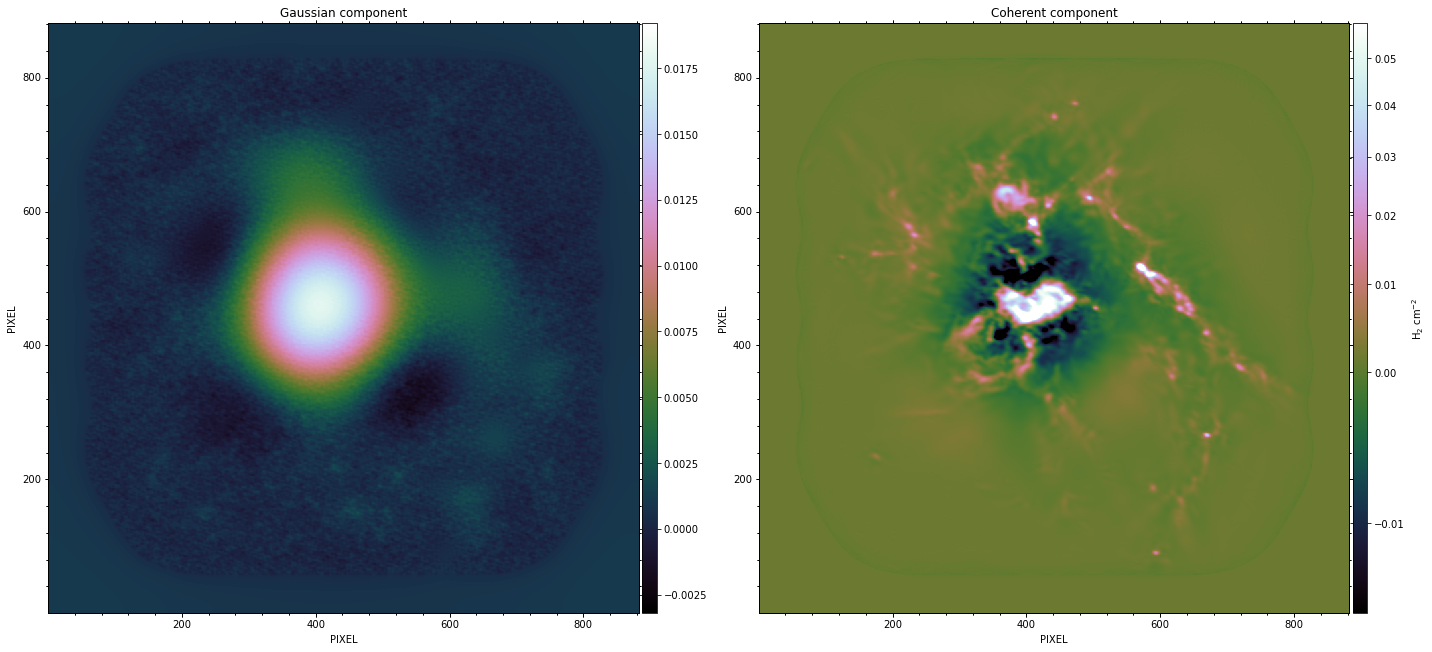

In [8]:
fig_all = plt.figure(1, figsize=(20,10))

#figfile = outputpath+imagename+'_gaussian.fits'
fig = aplpy.FITSFigure(fits.PrimaryHDU(Gaussian.real), figure=fig_all, convention='calabretta',subplot=(1, 2, 1))
fig.show_colorscale(cmap='cubehelix')
fig.add_colorbar()
fig.set_title('Gaussian component')

#figfile = outputpath+imagename+'_cohe.fits'
fig = aplpy.FITSFigure(fits.PrimaryHDU(coherent.real), figure=fig_all, convention='calabretta',subplot=(1, 2, 2))
fig.show_colorscale(cmap='cubehelix',stretch='sqrt')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')
fig.set_title('Coherent component')

plt.tight_layout()
#plt.savefig(outputpath+'pngs/'+imagename+'_gaussian_coherent.png')

### Plot Fourier vs Wavelet power spectra

Cutoff between 6.57 arcsec and 36.1 arcsec.


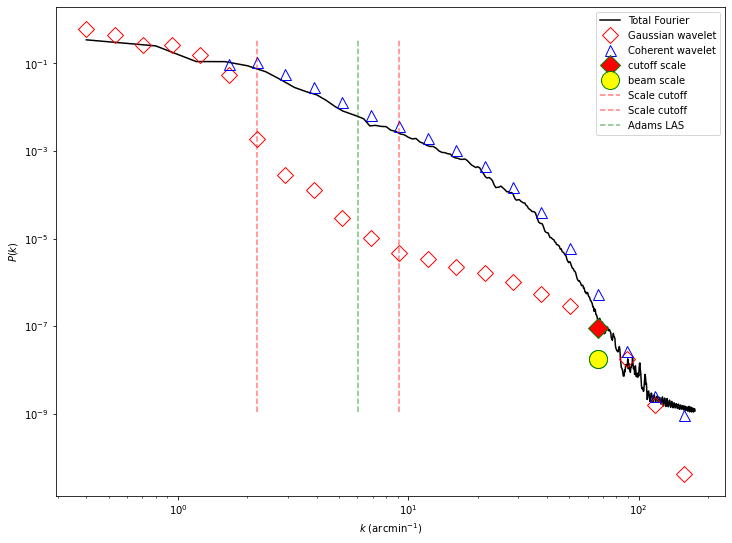

In [44]:
cutoff1 = 6
cutoff2 = 11

plt.figure(figsize(12,9))
plt.plot(tab_k, spec_k, color='black',label=r'Total Fourier')
plt.plot(wav_k[:-1], S1a[2,:-1],'D', markersize = 11, markerfacecolor='none', markeredgecolor='red', label='Gaussian wavelet')
plt.plot(wav_k[:-1], S1a[1,:-1],'^', markersize = 11, markerfacecolor='none', markeredgecolor='blue', label='Coherent wavelet')
plt.plot(wav_k[18], S1a[2,18],'D', markersize = 14, markerfacecolor='red', markeredgecolor='green', label='cutoff scale')
plt.plot([60/0.9,60/0.9],[S1a[2,19],S1a[2,19]],'o', markersize = 18, markerfacecolor='yellow', markeredgecolor='green', label='beam scale')
plt.plot([wav_k[cutoff1],wav_k[cutoff1]],[np.min(spec_k),np.max(spec_k)],'--',color='red',alpha=0.5,label='Scale cutoff')
plt.plot([wav_k[cutoff2],wav_k[cutoff2]],[np.min(spec_k),np.max(spec_k)],'--',color='red',alpha=0.5,label='Scale cutoff')
plt.plot([60/9.9,60/9.9],[np.min(spec_k),np.max(spec_k)],'--',color='green',alpha=0.5,label='Adams LAS')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

#plt.savefig(outputpath+'pngs/'+imagename+'_scales.png')

print('Cutoff between '+np.str_(60./wav_k[cutoff2])[:4]+' arcsec and '+np.str_(60./wav_k[cutoff1-1])[:4]+' arcsec.')

In [43]:
9.9*6

59.400000000000006

### Add large scales to coherent part

In [34]:
coherent2 = np.sum(wt[M:2*M,:,:],axis=0) + np.sum(wt[2*M:2*M+cutoff1,:,:],axis=0) + meanim
Gaussian2 = np.sum(wt[2*M+cutoff1:3*M,:,:],axis=0) + meanim

INFO: Auto-setting vmin to  2.981e-04 [aplpy.core]
INFO: Auto-setting vmax to  2.643e-03 [aplpy.core]


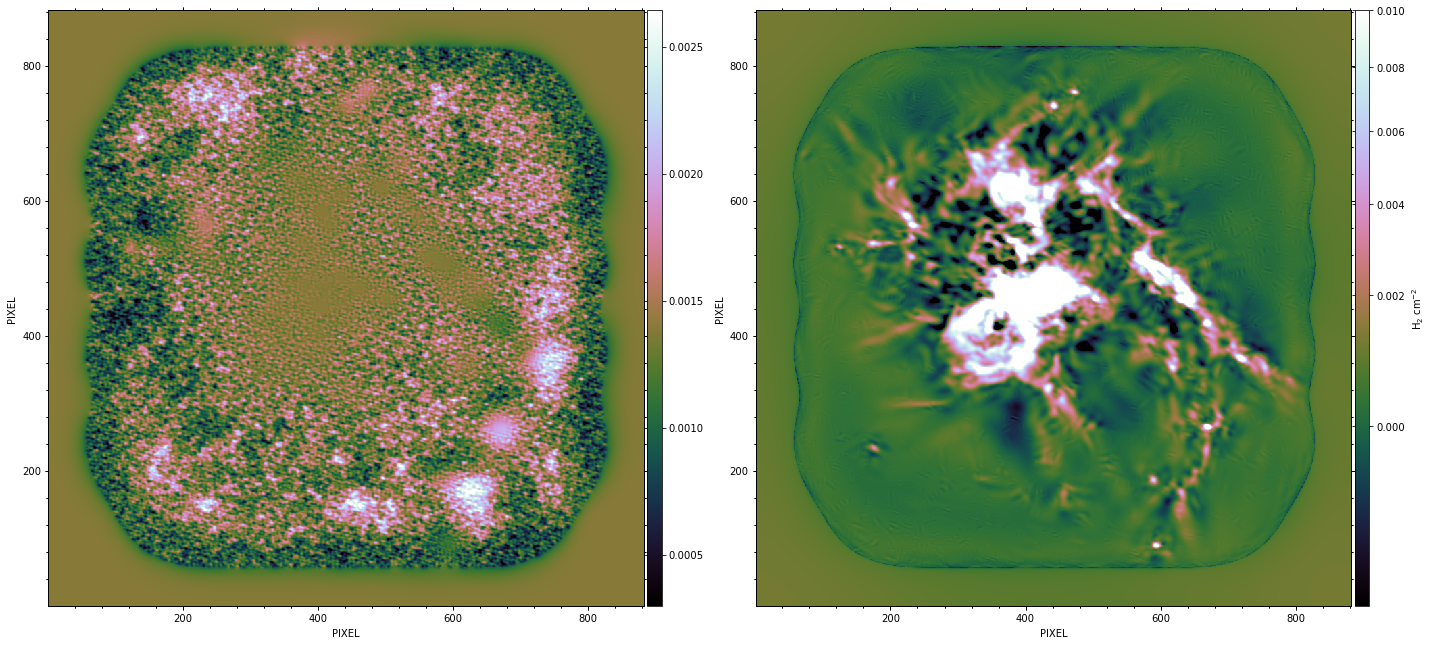

In [35]:
fig_all = plt.figure(1, figsize=(20,10))

fig = aplpy.FITSFigure(fits.PrimaryHDU(Gaussian2.real), figure=fig_all, convention='calabretta',subplot=(1, 2, 1))
fig.show_colorscale(cmap='cubehelix')
fig.add_colorbar()

fig = aplpy.FITSFigure(fits.PrimaryHDU(coherent2.real), figure=fig_all, convention='calabretta',subplot=(1, 2, 2))
fig.show_colorscale(cmap='cubehelix',stretch='sqrt',vmin=-0.001,vmax=0.01)
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')
tight_layout()

### Integrate over cutoff interval

In [51]:
coherent3 = np.sum(wt[M+cutoff1:M+cutoff2,:,:],axis=0) + meanim
Gaussian3 = np.sum(wt[2*M+cutoff1:2*M+cutoff2,:,:],axis=0) + meanim
#Gaussian3 = wt[2*M+6,:,:] + meanim

INFO: Auto-setting vmin to  6.293e-04 [aplpy.core]
INFO: Auto-setting vmax to  2.316e-03 [aplpy.core]


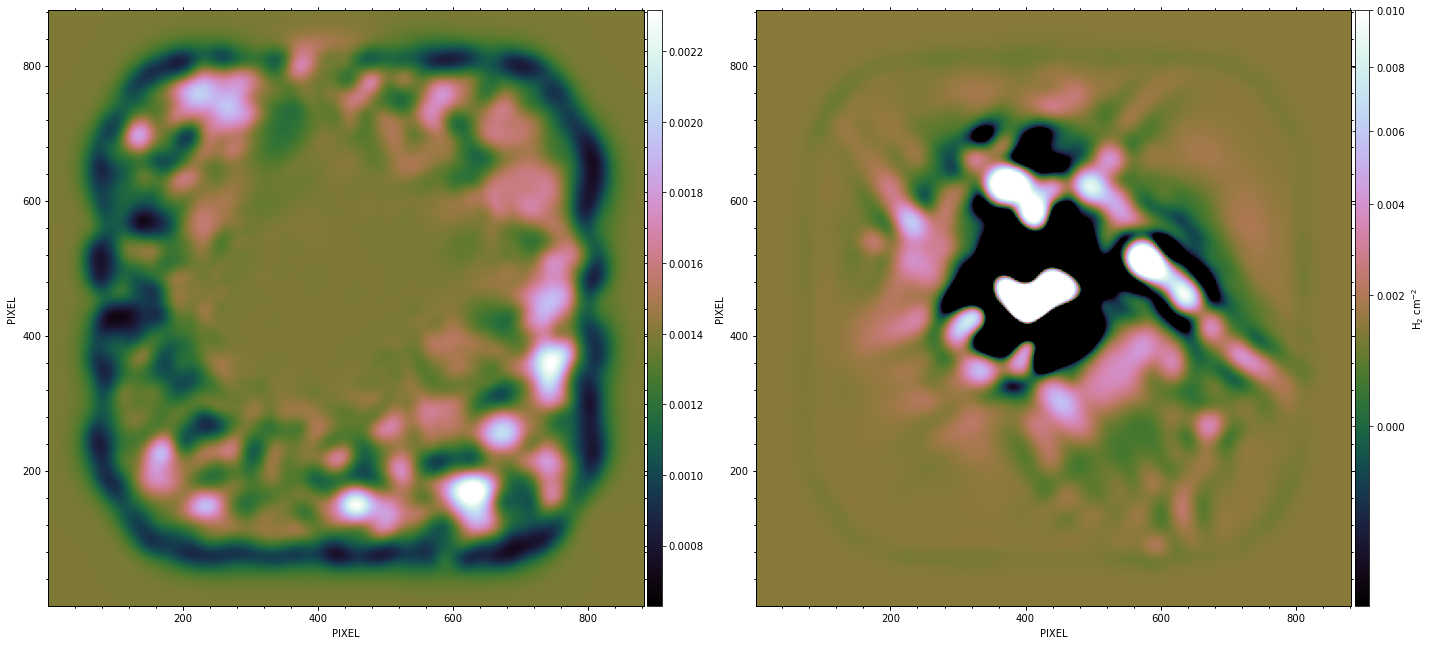

In [52]:
fig_all = plt.figure(1, figsize=(20,10))

fig = aplpy.FITSFigure(fits.PrimaryHDU(Gaussian3.real), figure=fig_all, convention='calabretta',subplot=(1, 2, 1))
fig.show_colorscale(cmap='cubehelix')
fig.add_colorbar()

fig = aplpy.FITSFigure(fits.PrimaryHDU(coherent3.real), figure=fig_all, convention='calabretta',subplot=(1, 2, 2))
fig.show_colorscale(cmap='cubehelix',stretch='sqrt',vmin=-0.001,vmax=0.01)
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')
tight_layout()

### Integrate above

In [27]:
Gaussian4 = np.sum(wt[2*M:2*M+6,:,:],axis=0) + meanim

INFO: Auto-setting vmin to -3.046e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.915e-02 [aplpy.core]


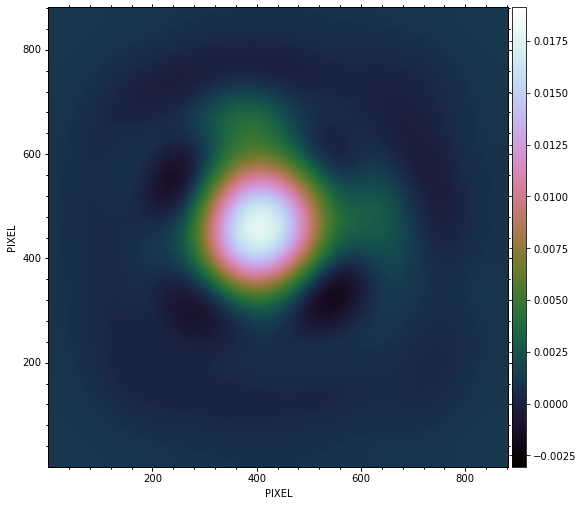

In [29]:
fig_all = plt.figure(1, figsize=(15,15))

fig = aplpy.FITSFigure(fits.PrimaryHDU(Gaussian4.real), figure=fig_all, convention='calabretta',subplot=(1, 2, 1))
fig.show_colorscale(cmap='cubehelix')
fig.add_colorbar()

tight_layout()

So, at scales smaller than ~36.1'' the diffuse Gaussian fluctuations drop until ~6.57''. Below ~6.57'', it is mainly noise without structure for the Gaussian component.

However, we are looking for low frequencies filtering, not high frequencies, so I am a bit confused. In any case, normally, for Herschel data without filtering for example, we would expect a power spectrum for the Gaussian part that is less steep. The steep power law means that we miss some signal.

### Run decomposition with 2 times more scales

In [6]:
#Generate the vector of scales wav_k2
na,nb = im_original.shape
ko= 5.336
delta = (2.*np.sqrt(-2.*np.log(.75)))/(2*ko)
nx = np.max(np.array([na,nb]))

M=int(np.log(nx)/delta)
a2=np.zeros(M)
a2[0]=np.log(nx)

for i in range(M-1):
    a2[i+1]=a2[i]-delta

a2=np.exp(a2)
wav_k2 = 1. / (a2 * reso)

In [7]:
#Set a list of q
q=[2.0]*47
wt, S11a, wav_k, S1a, q = fan_trans(im_original, scales=wav_k2, reso=reso, q=q, smooth=True, skewl=0.4,qdyn=False,nan_frame=True)

print(q)

  0%|          | 0/47 [00:00<?, ?it/s]

[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]


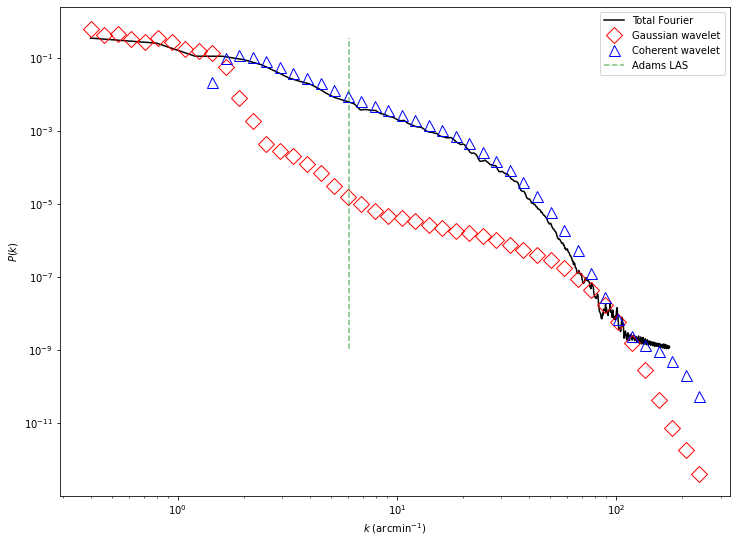

In [14]:
plt.figure(figsize(12,9))
plt.plot(tab_k, spec_k, color='black',label=r'Total Fourier')
plt.plot(wav_k[:-1], S1a[2,:-1],'D', markersize = 11, markerfacecolor='none', markeredgecolor='red', label='Gaussian wavelet')
plt.plot(wav_k[:-1], S1a[1,:-1],'^', markersize = 11, markerfacecolor='none', markeredgecolor='blue', label='Coherent wavelet')
plt.plot([60/9.9,60/9.9],[np.min(spec_k),np.max(spec_k)],'--',color='green',alpha=0.5,label='Adams LAS')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

And bim! With an higher resolution in scales we see a small plateau just above Adam's filtering scale at 9.9''. I would expect a plateau like this for low frequencie filtering. 

Then, I suspect that the larger scales in the Gaussian part somehow make the connection with the largest scales, which in fact probably belong to the coherent part. 